### -------------------------------------------------------------------------------------------------------------

#### This project explores the relationship between a nation's overall education level and people's willingness to have children.

#### For this project, data is retrieved from World Bank Open Data API using wbgapi package.

#### Author - Ketan Ingale

### -------------------------------------------------------------------------------------------------------------


#### Introduction

About 50 years ago, when china just finished its four year civil war and had its new regime established, every industry was waiting for recovery. The development of the society needed manpower and under this consideration, new China's government encouraged its people to bear as many children as the can. At that time, it was very common that a family has 4 to 5 children. Mother who bore lots of kids was known as "Mother Heroine". This movement significantly increased population of Chine and ended up with well-known movement - "The One Chile Policy".

What interests me is that people in old China used to be proud to have a big family while as is well-known, a lot of developed countries are facing the problem of negative birth rate and population decrease nowadays. Similar issue exists in China's new generation as well. With more and more people have the opportunity to receive higher education, it seems people are less willing to establish family or have kids. Is this the effect of education? Is that the more education people get, the less they are willing to have children?

Therefore I decided to study the effect of education on people's willingness to have children.

To prove my guess on a data-driven way, I decided to find data that can guage:
1. People's chance to receive education of a country.
2. People's willingness to have children of a country.
And then compare across different countries to get a conclusion.

**_For 1st, I found the following data sources:_**
1. GDP per Capita: The higher GDP per Capita a country, the wealthier the country is, and people would have higher chance to receive education.
2. Total public spending on education as percentage of GDP: The higher public spending on education is the higher chance people would have to receive education.

**_For 2nd, I found the following data sources:_**
1. Birth Rate
2. Wanted Fertility Rate (Births per Woman)
3. Population Growth Rate

For countries, I want to have as plenty countries and I also want to compare across developed, developing and underdeveloped countries.

However, I ended up choosing fertility rate instead of wanted fertility rate as my research variable. This is because the data - wanted fertility rate is not available for most of the countries in database. Yes, I could have chosen the coutries for which the wanted fertility rate data is available. However, most of the countries turn out to be developed, high-income, European countries. This renders the study much less reliable. Also, there's obvious overlap between birth rate, population growth and fertility rate. Therefore, I decided to use fertility rate alone, which has most countries data available, as my research variable.

In [1]:
# Ignoring the warning calls
import warnings
warnings.filterwarnings('ignore')

#Ignoring the warning calls for rpy package
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging
rpy2_logger.setLevel(logging.ERROR)

The required packages for the project are as follows:
1. wbgapi -> API for fetching data from World Bank Open Data
2. pandas -> This is an open source data analysis and manipulation tool
3. ipywidgets -> This package is used for creating interactive HTML widgets
4. matplotlib -> It is a comprehensive library for creating static, animated, and interactive visualizations.
5. sklearn -> This is a machine learning library used for predictive data analysis
6. IPython.display -> This library is used for displaying the data in a more readable and user friendly format

In [2]:
# Enabling rpy2 to run Python and R together
%load_ext rpy2.ipython

# Importing the required packages
import wbgapi as wb
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from IPython.display import display, HTML

# Turning off the interactive mode 
plt.ioff()

As mentioned in the introduction, I will be using the following three datasets.

1. NY.GDP.PCAP.KD (GDP Per Capita)
2. SE.XPD.TOTL.GD.ZS (Total Government Expenditure on Education)
3. SP.DYN.TFRT.IN (Fertility Rate)

In [3]:
# Creating variables for the required indicators
gdpPerCapita = 'NY.GDP.PCAP.KD'
expenditureOnEducation = 'SE.XPD.TOTL.GD.ZS'
fertilityRate = 'SP.DYN.TFRT.IN'

# Creating the list of indicators for the dropdown
indicators = [gdpPerCapita, expenditureOnEducation, fertilityRate]

We need the list of the economies for constructing the dropdown along with the list of indicators we created earlier.

In [4]:
economyDF = wb.economy.DataFrame().iloc[:, 0:1].reset_index()
economyList = economyDF[['name', 'id']].values.tolist()

We are going to define the class for creating the dropdown and slider. This is also creating a line plot for the required indicator and the economy.

In [5]:
class App:
    def __init__(self):
        self._economy = self._createDropdown(economyList)
        self._indicator = self._createDropdown(indicators)
        self._plotContainer = widgets.Output()
        self._yearSlider, yearSliderBox = self._createYearSlider(1960, 2020)
        _appContainer = widgets.VBox([widgets.HBox([self._economy, self._indicator]), self._plotContainer, yearSliderBox], layout = widgets.Layout(align_items = 'center', flex = '3 0 auto'))
        self.container = widgets.VBox([widgets.HTML(('<h1>World Bank Open Data</h1>' '<h2>GDP, Expenditure on Education & Fertility Rate</h2>'), layout = widgets.Layout(margin = '0 0 5em 0')), widgets.HBox([_appContainer])], layout = widgets.Layout(flex='1 1 auto', margin = '0 auto 0 auto', max_width = '1024px'))
        self._updateApp()
        
    def _createDropdown(self, indicators):
        dropdown = widgets.Dropdown(options = indicators)
        dropdown.observe(self._onChange, names = ['value'])
        return dropdown
    
    def _createYearSlider(self, minYear, maxYear):
        yearSliderLabel = widgets.Label('Year Range: ')
        yearSlider = widgets.IntRangeSlider(min = minYear, max = maxYear, layout = widgets.Layout(width = '500px'))
        yearSlider.observe(self._onChange, names = ['value'])
        yearSliderBox = widgets.HBox([yearSliderLabel, yearSlider])
        return yearSlider, yearSliderBox
    
    def _createPlot(self, economy, indicator, yearRange):
        rawData = wb.data.DataFrame(indicator, economy, range(*yearRange), columns = 'series').reset_index()
        rawDataExcludeTwo = rawData.loc[:, ~rawData.columns.isin(['time'])]
        rawDataImputed = KNNImputer(n_neighbors = 3).fit_transform(rawDataExcludeTwo)
        df = pd.DataFrame(rawDataImputed, columns = rawDataExcludeTwo.columns.values)
        df.insert(loc = 0, column = 'time', value = rawData['time'])
        plt.figure(figsize = (16, 9))
        plt.plot(df['time'], df[indicator])
        plt.xticks(rotation = 90)
        
    def _onChange(self, _):
        self._updateApp()
        
    def _updateApp(self):
        economy = self._economy.value
        indicator = self._indicator.value
        yearRange = self._yearSlider.value
        self._plotContainer.clear_output(wait = True)
        print()
        with self._plotContainer:
            self._createPlot(economy, indicator, yearRange)
            plt.show()

In [6]:
app = App()
app.container

We will be fetching data from the World Bank Open Data using wbgapi package.

There are two commands to pull data from database.
1. wb.data.fetch()
2. wb.data.DataFrame()

The first command fetches the data in the form of a generator object, whereas the second command, fetches the data in a dataframe format.

For our convenience, we will use the second command as it is easy to work with data in dataframe.

In [7]:
# Reset index is used to convert multi-indices to columns
rawData = wb.data.DataFrame(indicators).reset_index()

# Using display package to render the data instead of print command for pretty print of dataframe
display(rawData)

,economy,series,YR1960,YR1961,YR1962,YR1963,YR1964,YR1965,YR1966,YR1967,...,YR2011,YR2012,YR2013,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019,YR2020
0,ABW,NY.GDP.PCAP.KD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26647.643540,26150.636940,27090.026166,27011.320316,28396.908423,28847.814058,29286.249320,NaN,NaN,NaN
1,ABW,SE.XPD.TOTL.GD.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.119130,6.549060,6.442960,5.851280,5.888270,5.491350,NaN,NaN,NaN,NaN
2,ABW,SP.DYN.TFRT.IN,4.82000,4.655000,4.471000,4.271000,4.059000,3.842000,3.625000,3.417000,...,1.779000,1.795000,1.813000,1.834000,1.854000,1.872000,1.886000,1.896000,1.901000,NaN
3,AFE,NY.GDP.PCAP.KD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1444.501381,1449.610605,1479.016654,1503.506640,1507.800256,1501.671310,1507.821357,1507.861055,1499.256275,1418.380523
4,AFE,SE.XPD.TOTL.GD.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.385980,5.509040,4.621735,4.916950,5.079005,4.881085,5.023130,4.951635,4.719300,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,ZMB,SE.XPD.TOTL.GD.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.800000,4.200000,4.300000,5.200000,4.624330,3.747920,3.729640,4.739740,4.465180,NaN
794,ZMB,SP.DYN.TFRT.IN,7.11500,7.169000,7.214000,7.249000,7.274000,7.291000,7.304000,7.317000,...,5.328000,5.233000,5.132000,5.026000,4.918000,4.814000,4.718000,4.633000,4.559000,NaN
795,ZWE,NY.GDP.PCAP.KD,1164.74025,1197.603795,1174.431444,1206.107233,1152.997692,1169.489415,1148.226118,1203.561658,...,1248.729206,1432.305854,1435.062663,1443.617777,1445.069702,1433.608776,1479.233468,1509.523735,1367.676915,1239.853584
796,ZWE,SE.XPD.TOTL.GD.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.070210,5.995980,6.138350,5.812790,5.472620,5.381060,3.587280,NaN,NaN


Before moving forward, let's see how did the world as a whole performed on the fronts of GDP per capita, total government expenditure on education and fetility rate.

In [8]:
# The economy for world is represented by WLD
gdpWLD = wb.data.DataFrame('NY.GDP.PCAP.KD', 'WLD', columns = 'series')
expEduWLD = wb.data.DataFrame('SE.XPD.TOTL.GD.ZS', 'WLD', columns = 'series')
fertWLD = wb.data.DataFrame('SP.DYN.TFRT.IN', 'WLD', columns = 'series')

In [9]:
gdpWLD.plot(kind = 'line', figsize = (16, 9))
expEduWLD.plot(kind = 'line', figsize = (16, 9))
fertWLD.plot(kind = 'line', figsize = (16, 9))

<AxesSubplot:xlabel='time'>

The data we pulled from the API contains lots of NaN values which makes plotting inconsistent. We will be replacing the NaN values, rather imputing the values. For imputing the values, we will be using KNN algorithm. KNN stands for K - Nearest Neighbors. It  is a simple, easy-to-implement supervised machine learning algorithm that can be used to solve both classification and regression problems. The KNN algorithm assumes that similar things exist in close proximity. In other words, similar things are near to each other.

## "Birds of a feather flock together."

The KNN algorithm hinges on this assumption being true enough for the algorithm to be useful. KNN captures the idea of similarity (sometimes called distance, proximity, or closeness) with some mathematics we might have learned in our childhood— calculating the distance between points on a graph.

In [10]:
rawDataExcludeTwo = rawData.loc[:, ~rawData.columns.isin(['economy', 'series'])]

imputer = KNNImputer(n_neighbors = 3)
rawDataImputed = imputer.fit_transform(rawDataExcludeTwo)

rawDataImputed = pd.DataFrame(rawDataImputed, columns = rawDataExcludeTwo.columns.values)
rawDataImputed.insert(loc = 0, column = 'series', value = rawData['series'])
rawDataImputed.insert(loc = 0, column = 'economy', value = rawData['economy'])
display(rawDataImputed)

,economy,series,YR1960,YR1961,YR1962,YR1963,YR1964,YR1965,YR1966,YR1967,...,YR2011,YR2012,YR2013,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019,YR2020
0,ABW,NY.GDP.PCAP.KD,8940.996066,9518.123169,10047.186370,10560.950075,11121.020614,11527.676797,12239.391738,12993.067550,...,26647.643540,26150.636940,27090.026166,27011.320316,28396.908423,28847.814058,29286.249320,31799.350291,32366.442006,28124.208734
1,ABW,SE.XPD.TOTL.GD.ZS,6.297333,6.300333,6.302667,6.305000,6.307000,6.309000,6.310333,6.310333,...,6.119130,6.549060,6.442960,5.851280,5.888270,5.491350,5.549673,5.667470,6.467520,5.754017
2,ABW,SP.DYN.TFRT.IN,4.820000,4.655000,4.471000,4.271000,4.059000,3.842000,3.625000,3.417000,...,1.779000,1.795000,1.813000,1.834000,1.854000,1.872000,1.886000,1.896000,1.901000,2.235587
3,AFE,NY.GDP.PCAP.KD,1083.117683,1068.463246,1106.309161,1149.546151,1179.324393,1204.306876,1191.441984,1144.294360,...,1444.501381,1449.610605,1479.016654,1503.506640,1507.800256,1501.671310,1507.821357,1507.861055,1499.256275,1418.380523
4,AFE,SE.XPD.TOTL.GD.ZS,5.550667,5.589667,5.630000,5.671667,5.714333,5.761000,5.814000,5.874667,...,4.385980,5.509040,4.621735,4.916950,5.079005,4.881085,5.023130,4.951635,4.719300,4.805097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,ZMB,SE.XPD.TOTL.GD.ZS,5.597417,4.626333,5.637119,5.638781,5.627203,5.606295,5.575847,5.542037,...,3.800000,4.200000,4.300000,5.200000,4.624330,3.747920,3.729640,4.739740,4.465180,3.986340
794,ZMB,SP.DYN.TFRT.IN,7.115000,7.169000,7.214000,7.249000,7.274000,7.291000,7.304000,7.317000,...,5.328000,5.233000,5.132000,5.026000,4.918000,4.814000,4.718000,4.633000,4.559000,5.361247
795,ZWE,NY.GDP.PCAP.KD,1164.740250,1197.603795,1174.431444,1206.107233,1152.997692,1169.489415,1148.226118,1203.561658,...,1248.729206,1432.305854,1435.062663,1443.617777,1445.069702,1433.608776,1479.233468,1509.523735,1367.676915,1239.853584
796,ZWE,SE.XPD.TOTL.GD.ZS,7.546000,5.970667,7.565333,7.578000,7.592667,7.608333,7.624333,7.640000,...,4.603173,6.070210,5.995980,6.138350,5.812790,5.472620,5.381060,3.587280,6.315057,4.685233


Since the data is now NaN free, we can get on with our work.

The data contaisn years from 1960 to 2020. For the assignment sake, we will be using the year 2017. Just a randomly picked year.

From the imputed data, we will fetch the data of the year 2017 and simplify it a little to plot and work on it.

In [11]:
data2017 = rawDataImputed[['economy', 'series', 'YR2017']]
display(data2017)

,economy,series,YR2017
0,ABW,NY.GDP.PCAP.KD,29286.249320
1,ABW,SE.XPD.TOTL.GD.ZS,5.549673
2,ABW,SP.DYN.TFRT.IN,1.886000
3,AFE,NY.GDP.PCAP.KD,1507.821357
4,AFE,SE.XPD.TOTL.GD.ZS,5.023130
...,...,...,...
793,ZMB,SE.XPD.TOTL.GD.ZS,3.729640
794,ZMB,SP.DYN.TFRT.IN,4.718000
795,ZWE,NY.GDP.PCAP.KD,1479.233468
796,ZWE,SE.XPD.TOTL.GD.ZS,5.381060


In [12]:
# Simplifying the dataframe using the pivot function
data2017 = data2017.pivot(index = 'economy', columns = 'series')
data2017 = data2017['YR2017'].reset_index()
data2017.columns.name = None
display(data2017)

,economy,NY.GDP.PCAP.KD,SE.XPD.TOTL.GD.ZS,SP.DYN.TFRT.IN
0,ABW,29286.249320,5.549673,1.886000
1,AFE,1507.821357,5.023130,4.493744
2,AFG,575.707053,3.373310,4.633000
3,AFW,1830.381840,3.431200,5.182391
4,AGO,3790.791565,2.466880,5.600000
...,...,...,...,...
261,XKX,3902.018669,5424.831751,2.020000
262,YEM,1311.843419,4.639640,3.890000
263,ZAF,5672.693089,6.113060,2.430000
264,ZMB,1354.407115,3.729640,4.718000


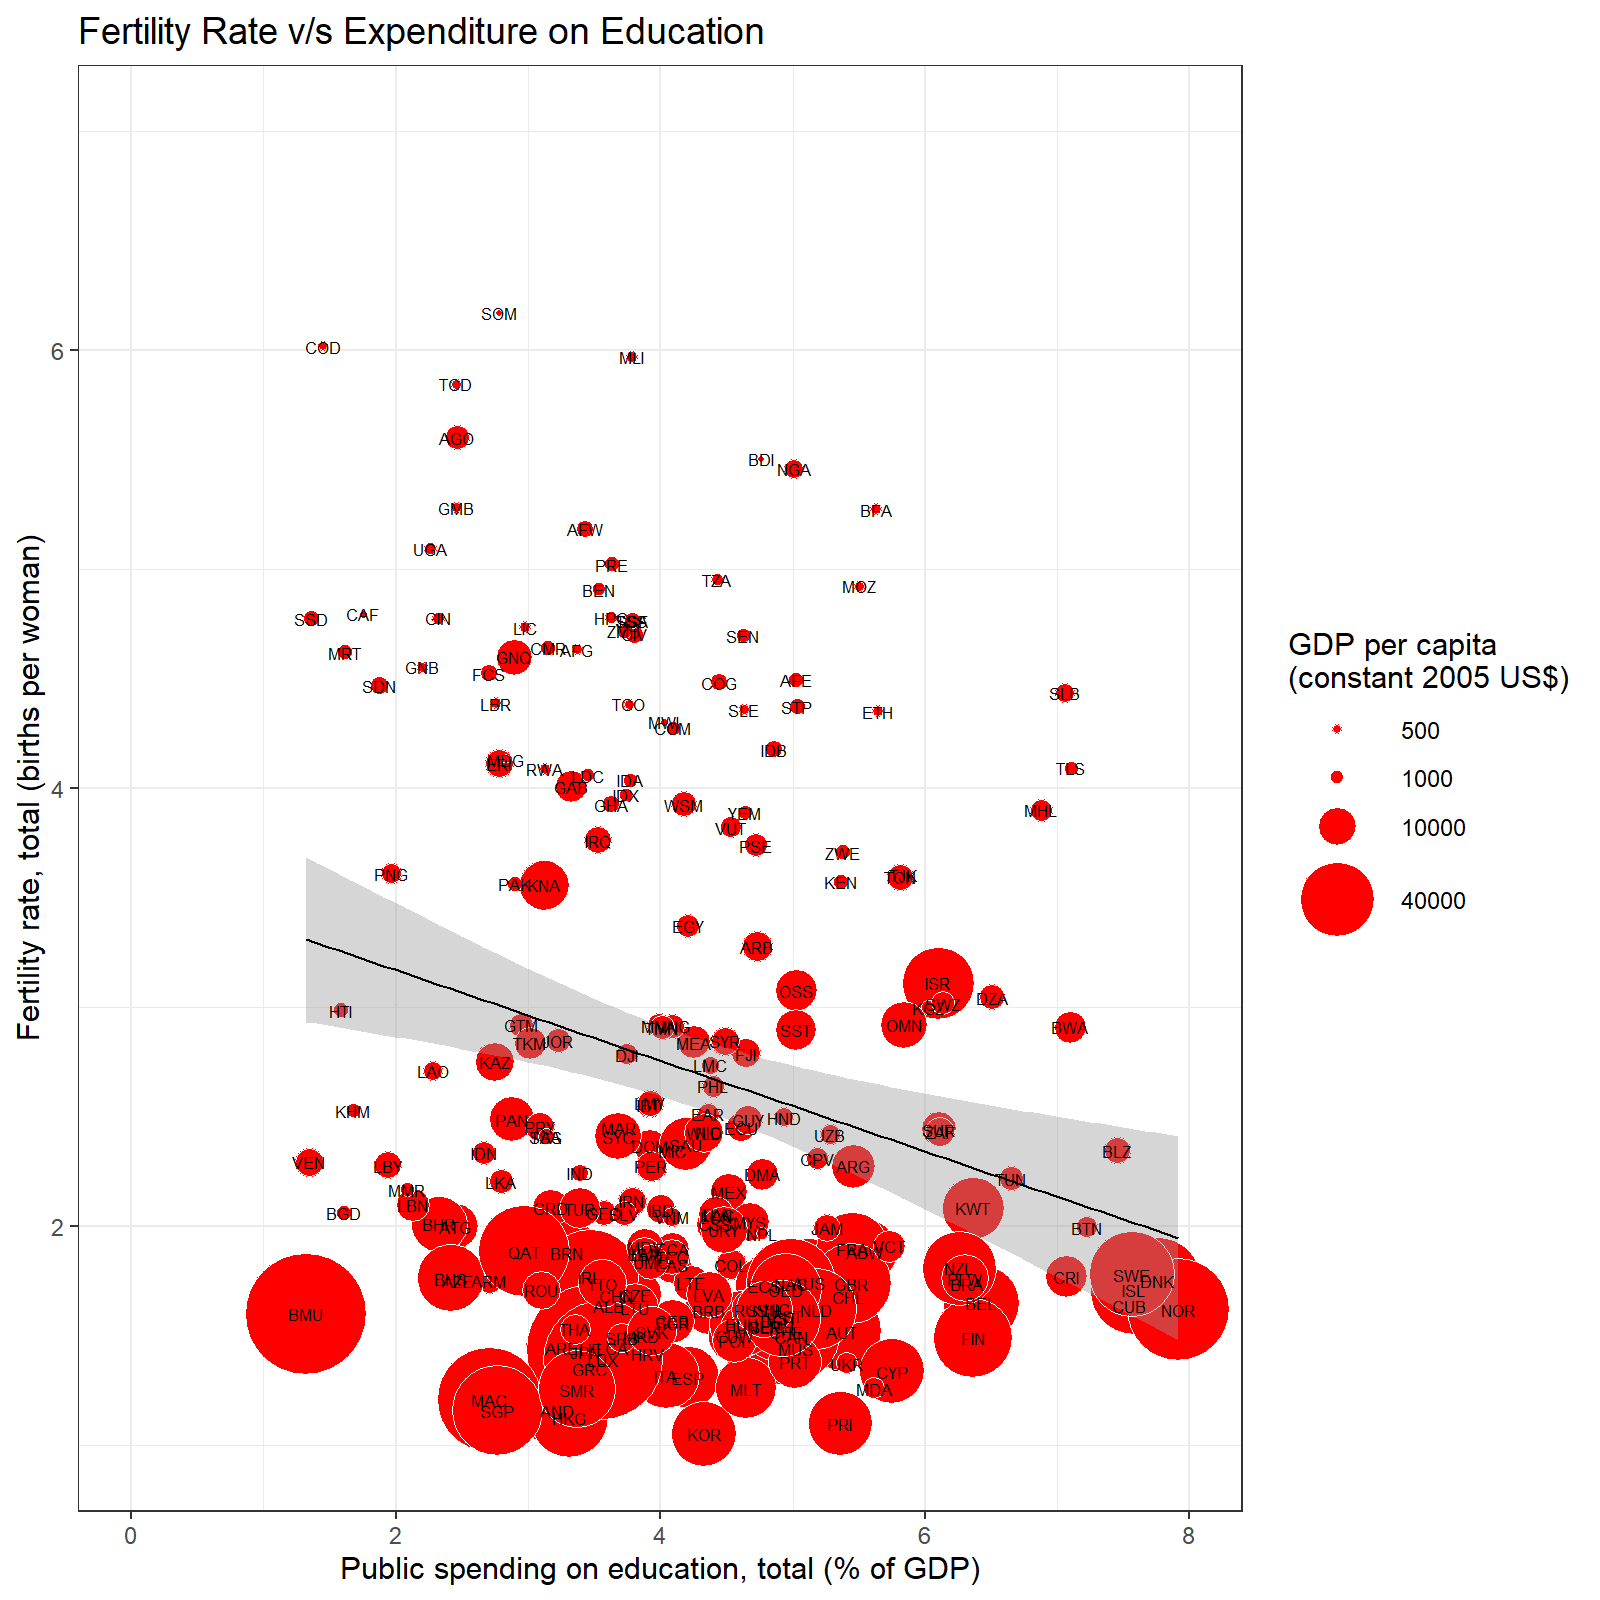

In [13]:
%%R -i data2017 -w 8 -h 8 --units in -r 200
# Import data2017 dataframe from global environment
# Make default figure size 8 by 8 inches with 200 dpi resolution

# Importing the ggplot library
library(ggplot2)

# Plotting the dataframe
# Bubble Chart for Expenditure on Education, Fertility Rate and GDP per Capita
ggplot(data2017, aes(x = SE.XPD.TOTL.GD.ZS, y = SP.DYN.TFRT.IN, size = NY.GDP.PCAP.KD, label = economy)) +
  geom_point(colour = "white", fill = "red", shape = 21) +
  scale_size_area(breaks = c(250, 500, 1000, 10000, 40000), "GDP per capita\n(constant 2005 US$)",max_size = 25) +
  stat_smooth(method = "lm", size = 0.5, colour = "black", alpha = 0.4, level = 0.95) +
  scale_x_continuous(name = "Public spending on education, total (% of GDP)", limits = c(0,8)) +
  scale_y_continuous(name = "Fertility rate, total (births per woman)", limits = c(1,7)) +
  geom_text(size = 2) +
  ggtitle("Fertility Rate v/s Expenditure on Education") +
  theme_bw()

# Results

**Bubble chart for fertility rate and expenditure on education**

This graph shows that there is a correlation between public spending on education with fertility rate, interpreted as the higher public spending on education, the lower the fertility rate of the country is. In the meantime, it is also observed that bigger circles tend to sit on the lower part of the graph, while small circles tend to sit on the upper part of the graph, which indicates that the higher GDP per capita of a country is, the lower is the fertility rate. This can also be interpreted as the higher GDP per capita of a country is, the more likely the country's spending on the education is high. The shadow area represents the 95% confidence level of the trend line. Therefore, we can conclude that education has effect on people's willingness of having children in a country.